# EDA of Stroke Dataset and Prediction of Strokes using Selected ML Algorithms

- toc: true
- badges: true

## Introduction

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.

In this project, we'll try to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. To do this, we'll use the [Stroke Prediction Dataset](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) provided by [fedesoriano](https://www.kaggle.com/fedesoriano) on Kaggle.

Each row in the dataset provides relavant information about the patient like age, smoking status, gender, heart disease, bmi, work type and in the end whether the patient suffered a stroke. This last parameter will be our target, which we'll try to predict using information from the other columns. 

The steps that we'll take:
- Setup and import the dataset
- Perform basic EDA and prepare the dataset for training
- Train and evaluate a baseline model
- Train multiple ML models and make predictions.
- Evaluate and compare their performance.

## Setup

In [1]:
import numpy as np # Linear algebra
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Data Visualizatin
import seaborn as sns # Data Visualization
from imblearn.over_sampling import SMOTE # Oversampling imbalanced classes
from sklearn.impute import SimpleImputer, MissingIndicator # Handle missing values
from sklearn.model_selection import train_test_split, cross_val_predict, cross_validate, GridSearchCV, StratifiedKFold 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay # Metrics
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from imblearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Models for prediciton
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# get the file path
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


In [2]:
file_path = "/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv"

In [3]:
# file size of the dataset
!ls -lh {file_path}

-rw-r--r-- 1 nobody nogroup 310K Oct 14 16:31 /kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


In [4]:
# look at the first few rows of the dataseet
!head {file_path}

id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1
56669,Male,81,0,0,Yes,Private,Urban,186.21,29,formerly smoked,1
53882,Male,74,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
10434,Female,69,0,0,No,Private,Urban,94.39,22.8,never smoked,1
27419,Female,59,0,0,Yes,Private,Rural,76.15,N/A,Unknown,1


**Observations**

* File size is 310 KB, thus it is safe to import the whole dataset.
* The delimiters are `,`
* `id` is the index column
* `stroke` is the prediction class in the last column

In [5]:
# Load the dataset into pandas DataFrame
df = pd.read_csv(file_path, index_col = ["id"])
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Basic EDA and Data Preparation

First, it is really important to separate the test data from the train data at this point, so that the transformers and models cannot learn from the test data itself. Before making a split, it is worth looking at the distribution of prediction class, to see if there is an imbalance and whether we will need to stratify the split.

Value Count in the prediction class - Stroke:
0    4861
1     249
Name: stroke, dtype: int64




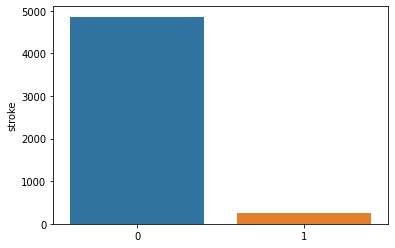

In [6]:
# Distribution of prediction class
stroke_val_count = df.stroke.value_counts()
print(f"Value Count in the prediction class - Stroke:\n{stroke_val_count}\n\n")

sns.barplot(x = stroke_val_count.index, y = stroke_val_count)
plt.show()

As we can see, the prediction class is highly imbalanced. Therefore, we'll need to stratify the split. Also, after making the split, it would be worth to generate artificial data in the training dataset to help the ML models distinguish better between the two categories of prediction class. 

In [7]:
# Separate the prediction class from the training features
X = df.copy()
y = X.pop("stroke")

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

We'll perform EDA on the dataset and use the observations that we make for building a data preparation pipeline as the last step.

#### Basic Inspection

In [8]:
# Look at the dataset
X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
25283,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked
43734,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked
47113,Female,67.0,0,0,Yes,Self-employed,Rural,110.42,24.9,never smoked
56996,Male,44.0,0,0,Yes,Private,Urban,65.41,24.8,smokes
26325,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown


In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4088 entries, 25283 to 31836
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4088 non-null   object 
 1   age                4088 non-null   float64
 2   hypertension       4088 non-null   int64  
 3   heart_disease      4088 non-null   int64  
 4   ever_married       4088 non-null   object 
 5   work_type          4088 non-null   object 
 6   Residence_type     4088 non-null   object 
 7   avg_glucose_level  4088 non-null   float64
 8   bmi                3918 non-null   float64
 9   smoking_status     4088 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 351.3+ KB


**Observations**

- There are 4088 entries in the train dataset.
- There are total 10 features which we can use to predict the occurance of stroke.
- There are some categorical features like `gender`, `work_type`, `Residence_type` of dtype `object`, which we'll need to be One Hot Encoded.
- Numerical features will need to be scaled.
- There are some missing values in the bmi column.

#### Null values

In [10]:
# Null values
X_train.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  170
smoking_status         0
dtype: int64

<AxesSubplot:ylabel='id'>

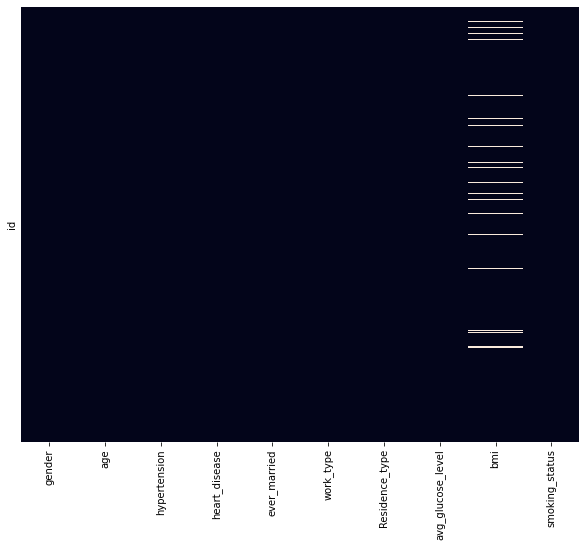

In [11]:
# Distribution of null values in the dataset
plt.figure(figsize = (10, 8))
sns.heatmap(X_train.isnull(), cmap = "rocket", yticklabels = "", cbar = None)

In [12]:
null_bmi = y_train.loc[X_train.bmi.isna()]
not_null_bmi = y_train.loc[X_train.bmi.notnull()]

print(f"""Non null bmi values:-

Stroke-no stroke ratio: {null_bmi.sum()/len(null_bmi)}


Null bmi values:-

Stroke-no stroke ratio: {not_null_bmi.sum()/len(not_null_bmi)}
""")

Non null bmi values:-

Stroke-no stroke ratio: 0.21764705882352942


Null bmi values:-

Stroke-no stroke ratio: 0.04134762633996937



**Observations**

Although Null values look to be evenly distributed in the heatmap, the ratio for occurance of stroke is significatly different in the entries with null bmi values. Thus, instead of dropping the null values, it would be better to impute the null values with median bmi value, and also encode the presence of null values in a separate column. This may help in better prediction of stroke.

#### Categorical columns

First it is worth inspecting the categories and their distributions in all categorical columns.

Value Counts of all categorical columns...

Values:-
Female    2395
Male      1692
Other        1
Name: gender, dtype: int64


Values:-
0    3691
1     397
Name: hypertension, dtype: int64


Values:-
0    3867
1     221
Name: heart_disease, dtype: int64


Values:-
Yes    2700
No     1388
Name: ever_married, dtype: int64


Values:-
Private          2332
Self-employed     667
children          554
Govt_job          522
Never_worked       13
Name: work_type, dtype: int64


Values:-
Urban    2069
Rural    2019
Name: Residence_type, dtype: int64


Values:-
never smoked       1501
Unknown            1247
formerly smoked     714
smokes              626
Name: smoking_status, dtype: int64




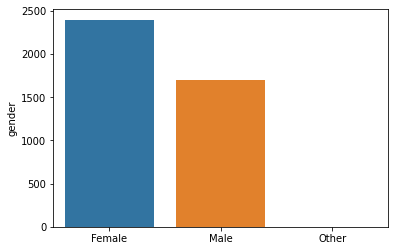

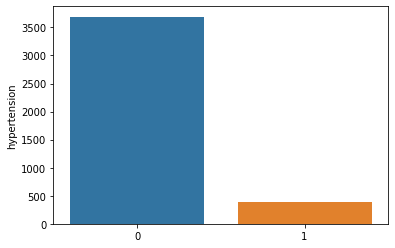

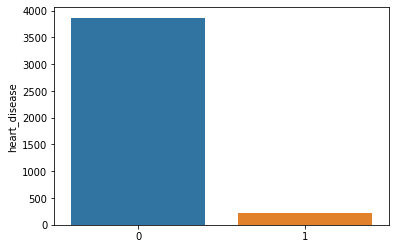

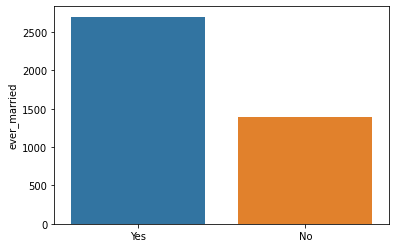

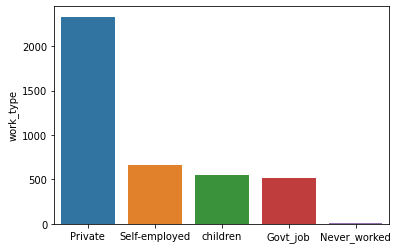

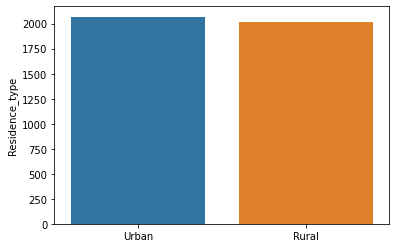

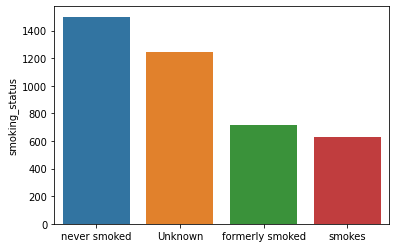

In [13]:
# Distribution of Categorical Features
cat_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

print("Value Counts of all categorical columns...\n")

for i, col in enumerate(cat_cols):
    val_count = X_train[col].value_counts()
    print(f"Values:-\n{val_count}\n\n")
    plt.figure(i)
    sns.barplot(x = val_count.index, y = val_count)

**Observation**

The categories in all the categorical features look ok, albeit most of the categories are unevenly distributed. Thus, we'll just one hot encode these columns.

#### Numerical Columns

In [14]:
# Look at the basic statistics

num_cols = ["age", "avg_glucose_level", "bmi"]

X_train[num_cols].describe()

,age,avg_glucose_level,bmi
count,4088.000000,4088.000000,3918.000000
mean,43.353288,106.317167,28.922180
std,22.596816,45.259652,7.928378
min,0.080000,55.120000,10.300000
25%,26.000000,77.312500,23.600000
50%,45.000000,91.945000,28.000000
75%,61.000000,114.197500,33.100000
max,82.000000,271.740000,97.600000


**Observations**

- `Age` appears to be slightly negatively skewed
- `avg_glucose_level` appears to be positively skewed
- min age of 0.08 suggests that age is stored in fractions, which needs further inspection.

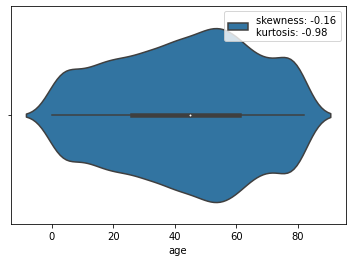

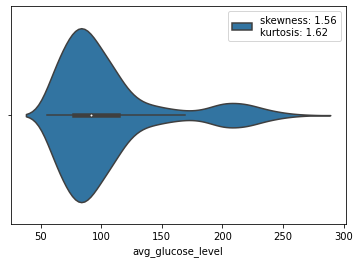

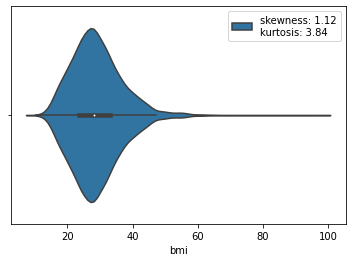

In [15]:
# Distribution of Numerical (Continuous) Features

for i, col in enumerate(num_cols):
    plt.figure(i)
    sns.violinplot(x = X_train[col])
    plt.legend([f"skewness: {X_train[col].skew():.2f}\nkurtosis: {X_train[col].kurtosis():.2f}"])

**Observations**

- `age` is very slightly negatively skewed with negative kurtosis.
- `avg_glucose_level` and `bmi` are positively skewed with sharp peaks(positive kurtosis)

Although some ML models assume normal distribution of data, they can work fine with data with small skewness and kurtosis values. Therefore, we'll just scale this data using MinMaxScaler.

In [16]:
# inspect`age` column
print(sorted(X_train.age.unique()))

[0.08, 0.24, 0.32, 0.4, 0.48, 0.56, 0.64, 0.72, 0.8, 0.88, 1.0, 1.08, 1.16, 1.24, 1.32, 1.4, 1.48, 1.56, 1.64, 1.72, 1.8, 1.88, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0]


**Observations**

Only values smaller than 2 are stored as floats. Thus, we can change the whole column to int datatype to make this feature uniform.

#### Build Column Transformer

Now, we can use combine all the observations that we made to build a data preparation pipeline with a column transformer. We'll use the transformer to:
- impute missing values
- change `age` column dtype to `int`
- add missing value indicator
- onehotencode categorical columns
- scale numerical features

In [17]:
# Columns
age_col = ["age"]
num_cols_without_age = ["avg_glucose_level", "bmi"]
cat_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]

# Scale the data
scaler = MinMaxScaler()

# handle missing values in `bmi`
imputer = SimpleImputer(strategy = "median")

# change dtype of `age`
def to_int(x):
    return pd.DataFrame(x).astype(int)

int_tr = FunctionTransformer(to_int)

In [18]:
# build transformer for `age` separately
age_transformer = make_pipeline(int_tr, scaler)

# build transformer for numeric cols without age
num_transformer = make_pipeline(imputer, scaler)

# missing_indicator
miss_ind = MissingIndicator()

# build transformer for categorical cols
cat_transformer = OneHotEncoder(drop = "first", handle_unknown = "ignore", sparse = False)

# combine transformers to make a single column transformer
ct = make_column_transformer((age_transformer, age_col), (num_transformer, num_cols_without_age), (miss_ind, num_cols_without_age), (cat_transformer, cat_cols), remainder = "passthrough")

In [19]:
ct.fit_transform(X_train).shape

(4088, 17)

#### SMOTE

We'll use imblearn's SMOTE over-sampling to balance the data. We'll implement this within the final pipeline with the training model.

In [20]:
sm = SMOTE(random_state = 42)
sm

SMOTE(random_state=42)

## Train and Evaluate a Baseline Model

A baseline model which doesn't use any of the features to make predictions will give a baseline score, that the future ML models should at least beat. This score will help to identify errors in model training and evaluation if the models perform worse than the baseline score. 

In [21]:
# Build imblearn pipeline with the DummyClassifier
base_model = DummyClassifier(strategy = 'prior')

base_pipe = make_pipeline(ct, sm, base_model)

# specify KFold strategy
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

#### Baseline scores

In [22]:
# Scores on multiple metrics from the DummyClassifier
cross_validate(base_pipe, X_train, y_train, cv = cv, n_jobs = -1, scoring = ["accuracy", "recall", "roc_auc", "f1"])

{'fit_time': array([0.0513134 , 0.0490582 , 0.05048561, 0.04655719, 0.0471642 ]),
 'score_time': array([0.04595423, 0.04224229, 0.04374504, 0.02858949, 0.04048371]),
 'test_accuracy': array([0.95110024, 0.95110024, 0.95110024, 0.95226438, 0.95104039]),
 'test_recall': array([0., 0., 0., 0., 0.]),
 'test_roc_auc': array([0.5, 0.5, 0.5, 0.5, 0.5]),
 'test_f1': array([0., 0., 0., 0., 0.])}

The model accuracy comes out to be really great at about 0.95. Although, it would generally be a good score to achieve. in this domain, a good accuracy score can be decieving. We can actually confirm this by looking at the test recall scores. All the test recall scores are 0, which means that the model failed to catch even a single True Positive. This is what we almost never want in the medical sphere. If the testing isn't prohibitively expensive or risky for the patient, which in this case it isn't, the test should aim for a high recall score and not a high accuracy score. That is why we'll judge our models using the roc_auc score primarily, which shows the relation between the True Positive Rate(TPR/recall) and False Positive Rate(FPR) of the model. For this baseline model, the roc_auc score comes out to be 0.5, which means the model isn't able to distinguish between the prediction classes at any of the thresholds, which we would expect from a dummy model.
We can also look at the roc_auc_curve of the model.

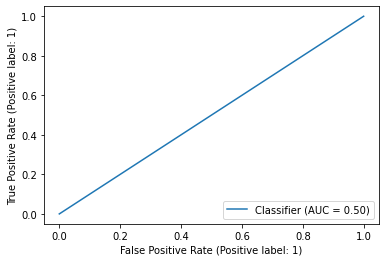

In [23]:
# ROC curve of DummyClassifier

base_preds_prob = cross_val_predict(base_pipe, X_train, y_train, cv = cv, n_jobs = -1, method = "predict_proba")[:, 1]

RocCurveDisplay.from_predictions(y_train, base_preds_prob)

## Model Selection

In this section, we'll train multiple ML models typically used for binary classification and compare their performance using the scores from `cross_validate`

In [24]:
# Specify ML models

models = {"Logistic_Regression": LogisticRegression(random_state = 42),
        "Ridge_Classification": RidgeClassifier(random_state = 42),
        "SVC": SVC(random_state = 42),
        "GaussianNB": GaussianNB(),
        "KNClassifier": KNeighborsClassifier(n_neighbors = 5),
        "RandomForestClassifier": RandomForestClassifier(max_depth = 10, n_jobs = -1, random_state = 42),
        "XGBClassifier": XGBClassifier(n_estimators = 50, learning_rate = 0.03, n_jobs = -1, 
                                       objective = "binary:logistic", eval_metric = "auc", tree_method = "hist", random_state = 42)}

In [25]:
# Model comparison on multiple metrics

scores = {}

for model_name, model in models.items():

    model_pipe = make_pipeline(ct, sm, model)
    
    cross_val = cross_validate(model_pipe, X_train, y_train, cv = cv, scoring = ["accuracy", "recall", "precision", "roc_auc", "f1"])
    del cross_val["fit_time"]
    del cross_val["score_time"]
    
    print(model_name + " :\n")
    
    for score_name, score_vals in cross_val.items():
        score_mean = score_vals.mean()
        score_std = score_vals.std()
        cross_val[score_name] = score_mean
        
        print(f"{score_name}: Mean: {(score_mean * 100):.2f} %   Std: {(score_std * 100):.2f}\n")
        
    print("\n", "-" * 50, "\n")
    
    scores[model_name] = cross_val

Logistic_Regression :

test_accuracy: Mean: 75.42 %   Std: 1.51

test_recall: Mean: 78.91 %   Std: 2.90

test_precision: Mean: 14.06 %   Std: 0.93

test_roc_auc: Mean: 84.92 %   Std: 0.96

test_f1: Mean: 23.86 %   Std: 1.40


 -------------------------------------------------- 

Ridge_Classification :

test_accuracy: Mean: 73.95 %   Std: 1.57

test_recall: Mean: 79.41 %   Std: 3.60

test_precision: Mean: 13.41 %   Std: 0.94

test_roc_auc: Mean: 85.04 %   Std: 1.38

test_f1: Mean: 22.93 %   Std: 1.47


 -------------------------------------------------- 

SVC :

test_accuracy: Mean: 81.97 %   Std: 1.27

test_recall: Mean: 45.26 %   Std: 10.97

test_precision: Mean: 12.36 %   Std: 1.46

test_roc_auc: Mean: 76.44 %   Std: 3.34

test_f1: Mean: 19.36 %   Std: 2.79


 -------------------------------------------------- 

GaussianNB :

test_accuracy: Mean: 25.37 %   Std: 4.74

test_recall: Mean: 99.50 %   Std: 1.00

test_precision: Mean: 6.12 %   Std: 0.43

test_roc_auc: Mean: 82.68 %   Std: 1

In [26]:
scores_df = pd.DataFrame.from_dict(scores, orient = 'index')
scores_df.sort_values(by = "test_roc_auc", ascending = False)

,test_accuracy,test_recall,test_precision,test_roc_auc,test_f1
Ridge_Classification,0.739481,0.794103,0.134058,0.850447,0.229299
Logistic_Regression,0.754158,0.789103,0.140608,0.849226,0.238578
GaussianNB,0.253661,0.995000,0.061211,0.826782,0.115301
XGBClassifier,0.772752,0.632692,0.128876,0.809516,0.213944
RandomForestClassifier,0.834148,0.406923,0.126488,0.802683,0.192495
SVC,0.819717,0.452564,0.123650,0.764393,0.193636
KNClassifier,0.837574,0.361923,0.118366,0.652839,0.177978


From the scores we get, linear models although lacking in accuracy porformed way much better than the others in recall, auc_roc, and f1 metrics. Their roc_auc score of above 80s but low precision score suggests that they can do well with threshold tuning. The tree models like RandomForestClassifier and XGBClassifier also achieved satisfactory performance with high accuracy and moderate roc_auc scores. KNClassifier and SVC performed the worst and may require some hyperparameter tuning. But time would be better spent tuning the linear models to get even better performance than to tune the other ML models.

## Model Tuning

We'll train `LogisticRegression` and `RidgeClassifier` ML models with `GridSearchCV` to find the best model and its parameters. We can then train this model on the full train dataset and then make predictions on the test dataset in the next section. 

In [27]:
# Initialize models and specify param_grid for GridSearchCV
models_and_params = {"LogisticRegression": [LogisticRegression(random_state = 42), 
                                            {"logisticregression__class_weight": [{0:1, 1: 1}, {0:1, 1:3}]}],
                    "RidgeClassification": [RidgeClassifier(random_state = 42), 
                                            {"ridgeclassifier__alpha": [1, 2, 3], "ridgeclassifier__class_weight": [{0:1, 1: 1}, {0:1, 1:3}]}]}

In [28]:
# Run GridSearchCV and store its results
tuning_scores = []
for model_name in models_and_params:
    model, params = models_and_params[model_name]
    
    model_pipe = make_pipeline(ct, sm, model)
    
    grid_cv = GridSearchCV(model_pipe, params, scoring = ["accuracy", "recall", "precision", "roc_auc", "f1"], n_jobs = -1, cv = cv, refit = False)
    
    grid_cv.fit(X_train, y_train)
    
    tuning_scores.append(grid_cv)

In [29]:
# Results for LogisticRegression
logistic_regression_grid_result = pd.DataFrame.from_dict(tuning_scores[0].cv_results_)
logistic_regression_grid_result = logistic_regression_grid_result[[
                                                    "param_logisticregression__class_weight", 
                                                    "mean_test_accuracy",
                                                    "mean_test_precision",
                                                    "mean_test_recall",
                                                    "mean_test_roc_auc",
                                                    "mean_test_f1"]]
logistic_regression_grid_result.sort_values(by = "mean_test_roc_auc", ascending = False)

,param_logisticregression__class_weight,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_roc_auc,mean_test_f1
0,"{0: 1, 1: 1}",0.754158,0.140608,0.789103,0.849226,0.238578
1,"{0: 1, 1: 3}",0.610319,0.104987,0.929744,0.847900,0.188645


In [30]:
# Results for RidgeClassifier
ridge_classifier_grid_result = pd.DataFrame.from_dict(tuning_scores[1].cv_results_)
ridge_classifier_grid_result = ridge_classifier_grid_result[[
                                                    "param_ridgeclassifier__alpha", 
                                                    "param_ridgeclassifier__class_weight", 
                                                    "mean_test_accuracy",
                                                    "mean_test_precision",
                                                    "mean_test_recall",
                                                    "mean_test_roc_auc",
                                                    "mean_test_f1"]]
ridge_classifier_grid_result.sort_values(by = "mean_test_roc_auc", ascending = False)

,param_ridgeclassifier__alpha,param_ridgeclassifier__class_weight,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_roc_auc,mean_test_f1
4,3,"{0: 1, 1: 1}",0.738258,0.133504,0.794103,0.850666,0.228482
2,2,"{0: 1, 1: 1}",0.739237,0.133963,0.794103,0.850492,0.229157
0,1,"{0: 1, 1: 1}",0.739481,0.134058,0.794103,0.850447,0.229299
5,3,"{0: 1, 1: 3}",0.582188,0.101112,0.959872,0.844802,0.182931
3,2,"{0: 1, 1: 3}",0.582432,0.101167,0.959872,0.844769,0.183022
1,1,"{0: 1, 1: 3}",0.583411,0.100952,0.954872,0.844712,0.182581


From these grid search, we have found that both the logistic regression and the ridge regression models are really close in performance on their roc_auc score which is the primary metric, and that the increasing alpha values in ridge classifier does help in improving the scores. Changing class weights improves test recall a lot but because of tradeoff between test recall and test precision, test precision takes a sligh hit, along with a large hit on test accuracy. Now, we have to make a call on what parameter is more important for us between test precision and test recall. with the roc_auc, the primary metric still high, we choose to prefer better test precision and test accuracy.

From this, we have identified the ML model - RidgeClassifier with the default class weghts 1:1 and alpha value of 3. Now, we will train this final model and make predictions on the test dataset and then evaluate those predictions.

## Final Model and Predictions

We can now train a RidgeClassifier with the default parameters with a imblearn Pipeline and then make predictions on the test dataset.

In [31]:
# Model Training
ridge = RidgeClassifier(random_state = 42, alpha = 3)

ridge_pipe = make_pipeline(ct, sm, ridge)

ridge_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function to_int at 0x7fc4d14a3200>)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                       

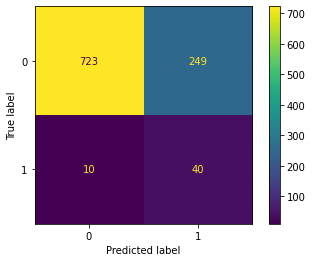

In [32]:
# Predictions on test dataset
preds = ridge_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, preds)

Accuracy Score: 0.7465753424657534
Precision Score: 0.1384083044982699
Recall Score: 0.8


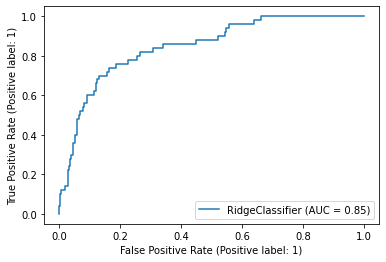

In [33]:
# Metrics for test predictions
RocCurveDisplay.from_estimator(ridge_pipe, X_test, y_test, name = "RidgeClassifier")
print("Accuracy Score:", accuracy_score(y_test, preds))
print("Precision Score:", precision_score(y_test, preds))
print("Recall Score:", recall_score(y_test, preds))

The classifier has predicted 723 True Negatives and 40 True Positives. There are 259 misclassifications too out of which 249 are False Positives. Considering that the predictions class was highly imbalanced to begin with, the model has worked really well in making correct classifications. Its AUC_ROC score on the test dataset is 0.85, similar to what we found on the train dataset. With more data, we can improve this score further. 


## Summary and Conclusion

In this project, we used the Stroke Dataset available on Kaggle to predict whether a patient would suffer from a stroke. First, we prepared the data for training and test by splitting it using train_test_split. Then we explored the data and understood where it needed some cleaning and preparation. With this knowledge, we developed imblearn's Pipelines to clean the data. We then explored multiple ML models and studied their performance through multiple metrics, primarily focusing on roc_auc scores. This choice of metrics was made with the knowledge that in the medicinal domain, the correct knowledge of True Positives is much more valuable than the wrong knowledge on False Positives.  We chose 2 linear models from this step for further model tuning and selection. RidgeClassifier turned out to be performing the best with its default parameters. We then trained this model and made predictions on the test data that we got from the split earlier. On the predictions, we achieved respectable scores on recall - 0.8 and on precision - 0.14. 